# Summary

Milestone 3 of reinforcement learning project. Notebook to get a GMRES that (1) works on GPU and (2) works with batched data.

## TODO

1. Finish testing.
2. Setup dataset from other notebook.
3. Integrate the GPU GMRES with the loss to see how much a single step will cost.
4. Improve loss from Milestone 2.
    1. Vectorize it.
    2. Additional terms for sparsity?
5. Begin to pretrain actor.
    1. First experiment with models.
        1. Minimize eye_dist.
        2. Try different layers.
        3. Try edge prediction. 
        4. REALLY TRY TO GET SPARSITY. (Log-sum penalty) ?
    2. Anything that works, store in a python file.
    3. Build out a python file that has models that have worked.
    4. Make sure to save weights and successfully plots to /Weights and /Plots
6. Train just on small (results).
7. Train just on large (results).
8. Train SMALLER -> freeze middle -> finetune on large.
9. If SMALLER -> LARGER leads to shorter training times and >= results, include as a novelty presented in paper (like many PDE discretization techniques, it is common to control the size, we found results that suggest that the model can generalize well to smaller discretization spaces and be applied effectively to larger state spaces).

# Dataset

Same helmholtz dataset from milestone 2.

In [1]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import torch
import matplotlib.pyplot as plt

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

In [2]:
def generate_2d_diffusion_spd(n, bump_range=(3, 4), contrast_range=(0.1, 5.0)):
    L = 1.0
    h = L / (n - 1)
    x = np.linspace(0, L, n)
    y = np.linspace(0, L, n)
    X, Y = np.meshgrid(x, y)
    
    # Random number of bumps
    num_bumps = np.random.randint(bump_range[0], bump_range[1])
    
    # Generate random 2D diffusion coefficient a(x,y)
    a = np.ones_like(X)
    for _ in range(num_bumps):
        center_x = np.random.uniform(0, L)
        center_y = np.random.uniform(0, L)
        width = np.random.uniform(0.03, 0.3)
        height = np.random.uniform(contrast_range[0], contrast_range[1])
        a += height * np.exp(-((X - center_x)**2 + (Y - center_y)**2) / (2 * width**2))
    
    # Build sparse matrix for 2D problem
    N = n * n  # total size
    main_diag = np.ones(N) * 1e-1 
    off_diag_x = np.zeros(N - 1)
    off_diag_y = np.zeros(N - n)
    
    for i in range(n):
        for j in range(n):
            idx = i * n + j
            
            if j < n - 1:  # x-direction neighbor
                a_mid = (a[i, j] + a[i, j + 1]) / 2
                off_diag_x[idx] = -a_mid / h**2
                main_diag[idx] += a_mid / h**2
                main_diag[idx + 1] += a_mid / h**2
                
            if i < n - 1:  # y-direction neighbor
                a_mid = (a[i, j] + a[i + 1, j]) / 2
                off_diag_y[idx] = -a_mid / h**2
                main_diag[idx] += a_mid / h**2
                main_diag[idx + n] += a_mid / h**2
    
    # Construct sparse matrix
    diagonals = [off_diag_y, off_diag_x, main_diag, off_diag_x, off_diag_y]
    offsets = [-n, -1, 0, 1, n]
    A = sp.diags(diagonals, offsets, format="csr")
    
    return A, a

True
True


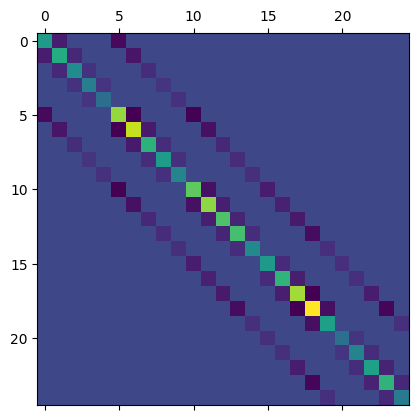

In [53]:
A = generate_2d_diffusion_spd(5)[0].toarray()

print(np.allclose(A, A.T))
eigenvalues = np.linalg.eig(A)
print(np.all(eigenvalues.eigenvalues > 0))

plt.matshow(generate_2d_diffusion_spd(5)[0].toarray())

In [4]:
def test_singularity(mat):
    det_mat = np.linalg.det(mat)
    print(det_mat)

    if np.isclose(det_mat, 0):
        print("Matrix is singular.")
        return False
        
    rank_mat = np.linalg.matrix_rank(mat)
    if rank_mat < mat.shape[0]:
        print("Matrix is singular.")
        return False
    
    print("Matrix is non-singular.")
        
    return True

In [5]:
def normalize_features(graph_data):
    x_mean = graph_data.mean()
    x_std = graph_data.std()
    out = (graph_data - x_mean) / (x_std)
    return out.float()

In [6]:
class HelmHoltzDataset(Dataset):
    def __init__(self, generator, checker, norm_feat, epoch_len, size=5, transform=None):
        super().__init__(None, transform)
        
        self.epoch_len = epoch_len
        self.mat_size = size
        
        self.generator = generator
        self.checker = checker
        
        self.norm_features = norm_feat

    def len(self):
        return self.epoch_len

    def get(self, idx):
        A = torch.from_numpy(self.generator(5)[0].toarray())
        A = normalize_features(A)
        A = torch.where(torch.abs(A) < 1e-1, torch.zeros_like(A), A)
        b = torch.randn(self.mat_size).unsqueeze(-1)
        
        return A, b

In [7]:
dataset = HelmHoltzDataset(generate_2d_diffusion_spd, test_singularity, normalize_features, 64*1000)
vdataset = HelmHoltzDataset(generate_2d_diffusion_spd, test_singularity, normalize_features, 64*100)

In [8]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
vdataloader = DataLoader(vdataset, batch_size=64, shuffle=True)

In [9]:
A, b = next(iter(dataloader))

85734500.0
Matrix is non-singular.


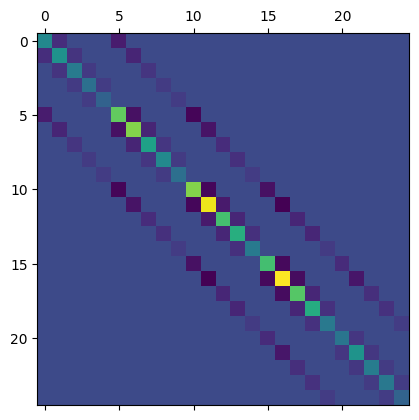

In [10]:
test_singularity(A[0])
plt.matshow(A[0])

## Loss Integration

Identity distance from Milestone 2 (with vectorized form). This will be the form going forward.

Update:
    Collapses onto zero matrix. Maximize distance from the zero matrix. This may also cause issues. They should be weighted.

\begin{equation}
    \mathcal{L} = \alpha_1\|XA - I\|_{fro} + \alpha_2\|A\|_1 - \alpha_3\|A\|_{fro}
\end{equation}
where $X$ is the input, $A$ is the output, and $\alpha = \left[1.0, 1.0, 0.01\right]$.

### TODO

In [11]:
from torch import nn

In [12]:
class InvDistance(nn.Module):
    def __init__(self, l1=1e-6, inv=1e-5, dev=1.0):
        super().__init__()
        self.l1 = l1
        self.inv = inv
        self.dev = dev
        self.size = 25
        
    def forward(self, inp, outp):
        avg_loss = 0
        inner_product = torch.bmm(outp, inp)
        identity = torch.eye(self.size).expand(64, self.size, self.size).to(outp.device)
        
        # TODO : Pre-pre, idk man
        
        avg_loss += torch.mean(torch.norm(inner_product - identity, p='fro', dim=(1, 2))) * self.inv

        _, S, _ = torch.linalg.svd(inner_product)
        deviation_from_one = torch.mean((S - 1)**2)  
        avg_loss += deviation_from_one * self.dev
        avg_loss += (torch.log(S.max()) - torch.log(S.min())) * 1e-2

        if self.l1 is not None:
            avg_loss += self.l1 * torch.norm(outp, p=1)
        
        return avg_loss

In [13]:
70/0.0004, 1/1e-5

(175000.0, 99999.99999999999)

# Models

Potential models for actor network.

**NOTE:** Aim for a model roughly 10 GBs in size. Need room for critic, actor, and GMRES. 

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn.utils as nn_utils

In [16]:
def shared_training_loop(epoches, criterion, train_loader, valid_loader, model, lr, b=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=1e-3)

    train_log, valid_log = np.zeros(epoches), np.zeros(epoches)
    size = 25
    
    for epoch in range(epoches):
        
        train_loss = 0
        model.train()
        t_loader = tqdm(train_loader, desc=f'Train', leave=False, mininterval=2.0)
        for batch in t_loader:
            A, b = batch
            A, b = A.to(device), b.to(device)
            output = model(A.view(64, size*size))
            loss = criterion(A, output.view(64, size, size))

            t_loader.set_postfix(train_loss=loss.item())
            train_loss += loss.item()

            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            
        valid_loss = 0
        model.eval()
        v_loader = tqdm(valid_loader, desc=f'Valid', leave=False, mininterval=2.0)
        for batch in v_loader:
            with torch.no_grad():
                A, b = batch
                A, b = A.to(device), b.to(device)
                output = model(A.view(64, size*size))
                loss = criterion(A, output.view(64, size, size))

                v_loader.set_postfix(valid_loss=loss.item())
                valid_loss += loss.item()
                
        print(f'Epoch: {epoch}, Train: {train_loss/len(t_loader)}, Valid: {valid_loss/len(v_loader)}')
        train_log[epoch], valid_log[epoch] = train_loss, valid_loss
        
        scheduler.step(valid_loss/len(v_loader))
        
    return train_log, valid_log

In [17]:
import matplotlib.pyplot as plt

In [41]:
def plot_training(train_log, valid_log, title='EX', filename='ex'):
    plt.plot(train_log/1000, label="Train")
    plt.plot(valid_log/100, label="Valid")
    plt.title(f'{title}: Train/Valid Log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.savefig(f'{filename}.png')
    plt.show()

# Linear Model

Small linear model. IDK man.

In [19]:
import torch.nn as nn

In [20]:
import torch
import torch.nn as nn

class FCN(nn.Module):
    def __init__(self, n=25, hidden=256):
        super().__init__()
        
        self.n = n
        lower_triangle_size = (n * (n + 1)) // 2
        
        self.fcn1 = nn.Linear(n * n, hidden)
        self.fcn2 = nn.Linear(hidden, hidden)
        self.fcn3 = nn.Linear(hidden, hidden)
        self.fcn4 = nn.Linear(hidden, hidden)
        self.fcn5 = nn.Linear(hidden, hidden)
        self.fcn6 = nn.Linear(hidden, lower_triangle_size)
        
        self.act = nn.ReLU()
        
    def forward(self, inpt):
        out = self.act(self.fcn1(inpt))
        out = self.act(self.fcn2(out))        
        out = self.act(self.fcn3(out))        
        out = self.act(self.fcn4(out))
        out = self.act(self.fcn5(out))
        
        # Output the lower triangular part
        lower_tri_values = self.fcn6(out)
        
        # Initialize a full zero matrix
        full_matrix = torch.zeros((64, self.n, self.n), device=lower_tri_values.device)
        
        # Fill in the lower triangular part of the matrix
        tril_indices = torch.tril_indices(self.n, self.n)
        full_matrix[:, tril_indices[0], tril_indices[1]] = lower_tri_values
        
        # Use symmetry to fill the upper triangular part
        diags = torch.diagonal(full_matrix, dim1=1, dim2=2).unsqueeze(-1) * torch.eye(25).to(device)
        full_matrix = full_matrix + torch.transpose(full_matrix, dim0=2, dim1=1) - diags
        
        return torch.where(torch.abs(full_matrix) < 1e-5, torch.zeros_like(full_matrix), full_matrix)

In [21]:
fcn = FCN()

In [22]:
criterion = InvDistance()

In [23]:
epoches = 100
loader = dataloader
vloader = vdataloader
model = fcn.to(device)
lr = 1e-5

In [24]:
train_log, valid_log = shared_training_loop(epoches, criterion, loader, vloader, model, lr)

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train: 0.38691115137934684, Valid: 0.2643792939186096


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2, Train: 0.17397415748238562, Valid: 0.1637936218082905


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3, Train: 0.1582612290084362, Valid: 0.15300712630152702


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4, Train: 0.14917680667340755, Valid: 0.14589311212301254


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11, Train: 0.1288740816116333, Valid: 0.1282772508263588


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12, Train: 0.12773760691285133, Valid: 0.12698703713715076


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22, Train: 0.12039119227975607, Valid: 0.12017949171364307


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23, Train: 0.11995740565657616, Valid: 0.11984312482178211


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24, Train: 0.11946637862175703, Valid: 0.11940442934632302


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 33, Train: 0.11668925328552723, Valid: 0.11668037883937359


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 34, Train: 0.11641149514168501, Valid: 0.1163126714527607


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 35, Train: 0.11624669057875872, Valid: 0.11629657223820686


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 45, Train: 0.11427419770509005, Valid: 0.11382131069898606


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 46, Train: 0.1140466312468052, Valid: 0.1140901705622673


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 47, Train: 0.11385609894245863, Valid: 0.11379008576273918


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 57, Train: 0.11247057528048754, Valid: 0.11287713058292866


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 58, Train: 0.11249036964774131, Valid: 0.11259694591164589


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 59, Train: 0.11236396443098784, Valid: 0.11238911665976048


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 69, Train: 0.11141630747914315, Valid: 0.11110285043716431


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 70, Train: 0.11125555896759033, Valid: 0.11153898805379868


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 71, Train: 0.11117328628897667, Valid: 0.11108075924217702


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 81, Train: 0.11036944025754929, Valid: 0.11012920267879962


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 82, Train: 0.11035226333141326, Valid: 0.11029748216271401


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 83, Train: 0.11025922748446465, Valid: 0.11002271279692649


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 88, Train: 0.10984258692711592, Valid: 0.10969321236014366


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 89, Train: 0.1098235033005476, Valid: 0.10961281016469002


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 90, Train: 0.10964394854009152, Valid: 0.10982809409499168


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 91, Train: 0.10968086487799883, Valid: 0.10971979960799218


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 97, Train: 0.10925011318176985, Valid: 0.10969184435904027


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [54]:
A, b = next(iter(dataloader))

In [73]:
def testing(A, model, ind=0):
    model.eval()
    with torch.no_grad():
        out = model(A.view(64, 25*25).to(device)).view(64, 25, 25).cpu()

    inner = A @ out
    
    acond = torch.mean(torch.norm(A, p="fro", dim=(1, 2)) * torch.norm(torch.linalg.inv(A), p="fro", dim=(1, 2)))
    icond = torch.mean(torch.norm(inner, p="fro", dim=(1, 2)) * torch.norm(torch.linalg.inv(inner), p="fro", dim=(1, 2)))
    
    print(f'Inner DET: {torch.mean(torch.linalg.det(inner))}')
    print(f'Output min: {out.min()}')

    # Create figures with colorbars
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    im1 = ax1.matshow(out[ind])
    ax1.set_title(f'Output')
    plt.colorbar(im1, ax=ax1)
    ax1.set_xticks([])
    ax1.set_yticks([])

    im2 = ax2.matshow(A[ind])
    ax2.set_title(f'Input Matrix A: {acond}')
    plt.colorbar(im2, ax=ax2)
    ax2.set_xticks([])
    ax2.set_yticks([])

    im3 = ax3.matshow(inner[ind])
    ax3.set_title(f'Inner Product: {icond}')
    plt.colorbar(im3, ax=ax3)
    ax3.set_xticks([])
    ax3.set_yticks([])

    plt.tight_layout()
    plt.savefig('EX.png')
    plt.show()

    return out

In [74]:
import os

def save_model(model, model_path):
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to: {model_path}")

# Save training and validation logs
def save_logs(train_log, valid_log, log_path):
    os.makedirs(os.path.dirname(log_path), exist_ok=True)
    np.savez(log_path, train_log=train_log, valid_log=valid_log)
    print(f"Logs saved to: {log_path}")

# Usage
model_path = "model.pth"
log_path = "RUNS/logs.npz"

save_model(model, model_path)
save_logs(train_log, valid_log, log_path)

Model saved to: model.pth
Logs saved to: RUNS/logs.npz


Inner DET: 0.008824733085930347
Output min: -0.3788236975669861


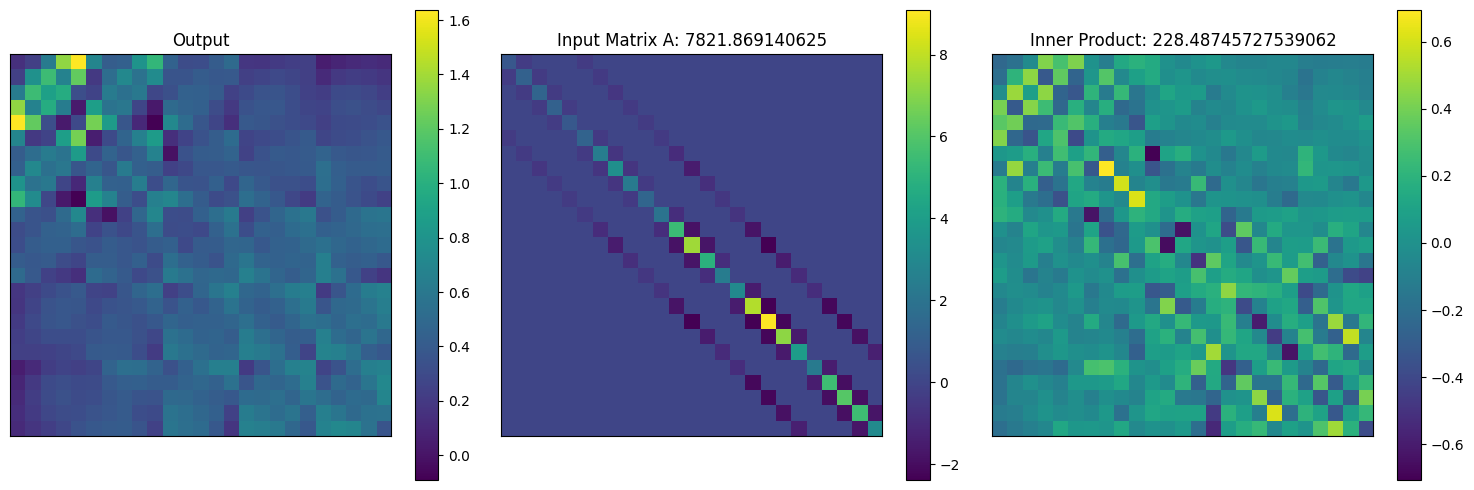

In [75]:
out = testing(A, fcn, ind=3)

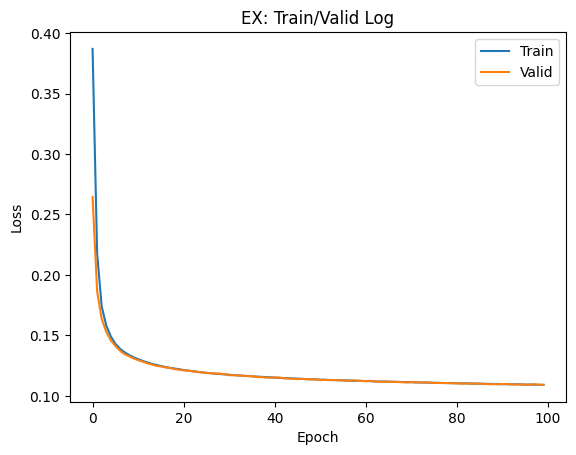

In [42]:
plot_training(train_log, valid_log)

In [29]:
criterion = InvDistance(inv=1e-4, dev=1.0)
epoches = 25

In [30]:
train_log_2, valid_log_2 = shared_training_loop(epoches, criterion, loader, vloader, model, lr)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train: 0.10970183315873146, Valid: 0.1099456125497818


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Train: 0.10963884692639113, Valid: 0.10963580034673213


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8, Train: 0.10925377264618874, Valid: 0.10920703575015069


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9, Train: 0.1092473724707961, Valid: 0.10924402303993702


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12, Train: 0.10914717373251916, Valid: 0.10909166865050793


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 17, Train: 0.10886578684300184, Valid: 0.1088311630487442


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18, Train: 0.10878622687608004, Valid: 0.10871307298541069


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19, Train: 0.10867225974053145, Valid: 0.10868670612573623


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



A COND: 7347.47265625
Inner DET: 0.012206198647618294
Inner COND: 236.52215576171875
tensor(-0.4316)


tensor([[[ 0.0475,  0.1747,  0.2714,  ...,  0.1901,  0.1348,  0.0793],
         [ 0.1747,  0.2484,  0.4992,  ...,  0.2153,  0.1556,  0.0848],
         [ 0.2714,  0.4992,  0.5585,  ...,  0.2234,  0.1509,  0.0394],
         ...,
         [ 0.1901,  0.2153,  0.2234,  ...,  0.4423,  0.3587,  0.8061],
         [ 0.1348,  0.1556,  0.1509,  ...,  0.3587,  0.5597,  0.6644],
         [ 0.0793,  0.0848,  0.0394,  ...,  0.8061,  0.6644,  0.2086]],

        [[-0.0220,  0.1601,  0.3674,  ...,  0.1444,  0.1162,  0.0600],
         [ 0.1601,  0.4043,  0.6953,  ...,  0.2188,  0.1685,  0.0762],
         [ 0.3674,  0.6953,  0.5678,  ...,  0.2645,  0.2054,  0.0803],
         ...,
         [ 0.1444,  0.2188,  0.2645,  ...,  0.4844,  0.3801,  0.7912],
         [ 0.1162,  0.1685,  0.2054,  ...,  0.3801,  0.5823,  0.5516],
         [ 0.0600,  0.0762,  0.0803,  ...,  0.7912,  0.5516,  0.1192]],

        [[-0.0544,  0.2601,  0.4518,  ..., -0.0334,  0.0133,  0.0405],
         [ 0.2601,  0.4064,  0.4439,  ...,  0

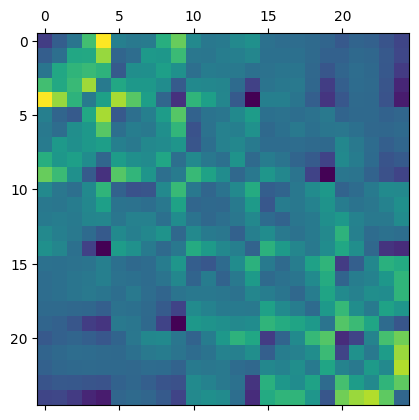

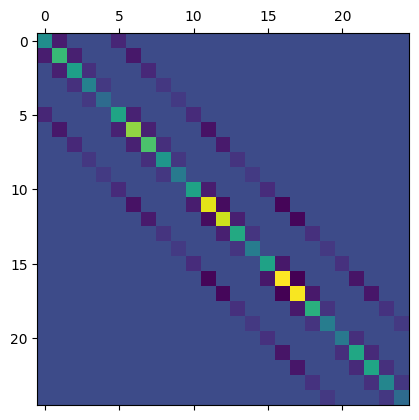

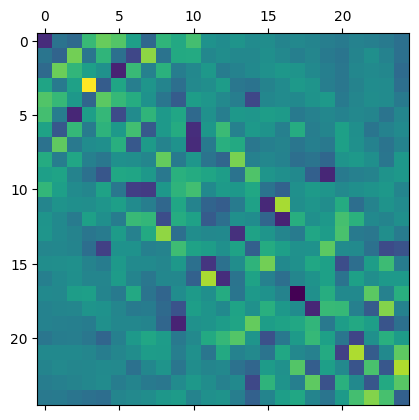

In [31]:
testing(A, fcn)

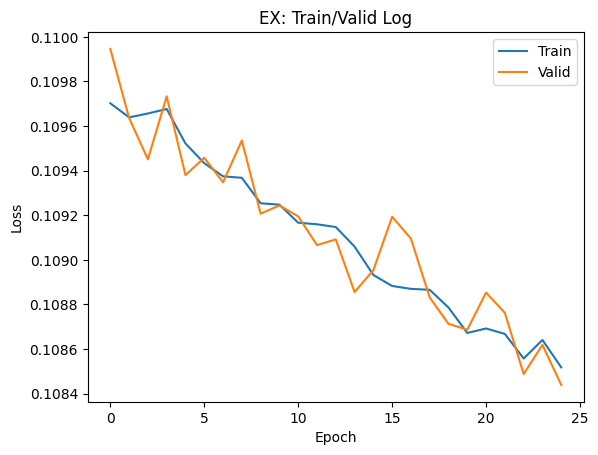

In [43]:
plot_training(train_log_2, valid_log_2)

In [33]:
criterion = InvDistance(inv=1e-2, dev=1.0)
epoches = 75

In [34]:
train_log_3, valid_log_3 = shared_training_loop(epoches, criterion, loader, vloader, model, lr)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train: 0.1765893469899893, Valid: 0.17677971065044404


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Train: 0.17658985063433646, Valid: 0.17646703049540519


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8, Train: 0.17635408501327038, Valid: 0.17637314572930335


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9, Train: 0.17625513108074664, Valid: 0.17610394060611725


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, Train: 0.17621891532838344, Valid: 0.17627692133188247


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17, Train: 0.17596318238973618, Valid: 0.17598589718341828


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18, Train: 0.17589057014882564, Valid: 0.17612506598234176


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19, Train: 0.17588795560598375, Valid: 0.17556646332144737


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 27, Train: 0.17562398374080657, Valid: 0.17558763772249222


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 28, Train: 0.17552344857156277, Valid: 0.17537502497434615


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 29, Train: 0.17560430341959, Valid: 0.17579568579792976


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 38, Train: 0.175206176802516, Valid: 0.17522567883133888


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 39, Train: 0.17521744288504124, Valid: 0.175126616358757


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 47, Train: 0.17460135802626608, Valid: 0.1746261654794216


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 51, Train: 0.17459780429303645, Valid: 0.1743610394001007


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 52, Train: 0.17459011501073837, Valid: 0.17442491620779038


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 59, Train: 0.17450283321738244, Valid: 0.17466683954000473


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 64, Train: 0.1745271918475628, Valid: 0.17445149630308152


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 65, Train: 0.1745190455764532, Valid: 0.17444736391305923


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 72, Train: 0.17436059504747392, Valid: 0.1745366570353508


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



A COND: 7347.47265625
Inner DET: 0.008538762107491493
Inner COND: 230.38461303710938
tensor(-0.4547)


tensor([[[ 6.0281e-02,  1.8244e-01,  2.7458e-01,  ...,  2.0993e-01,
           1.6352e-01,  1.0971e-01],
         [ 1.8244e-01,  2.5879e-01,  5.0701e-01,  ...,  2.3664e-01,
           1.7610e-01,  1.1528e-01],
         [ 2.7458e-01,  5.0701e-01,  5.7108e-01,  ...,  2.3728e-01,
           1.6838e-01,  6.5585e-02],
         ...,
         [ 2.0993e-01,  2.3664e-01,  2.3728e-01,  ...,  4.5986e-01,
           3.6713e-01,  8.1888e-01],
         [ 1.6352e-01,  1.7610e-01,  1.6838e-01,  ...,  3.6713e-01,
           5.6752e-01,  6.8971e-01],
         [ 1.0971e-01,  1.1528e-01,  6.5585e-02,  ...,  8.1888e-01,
           6.8971e-01,  2.6502e-01]],

        [[-6.0535e-03,  1.5883e-01,  3.6382e-01,  ...,  1.6347e-01,
           1.4120e-01,  8.1389e-02],
         [ 1.5883e-01,  4.0225e-01,  6.9078e-01,  ...,  2.3117e-01,
           1.8044e-01,  1.0397e-01],
         [ 3.6382e-01,  6.9078e-01,  5.7677e-01,  ...,  2.6924e-01,
           2.1121e-01,  9.8089e-02],
         ...,
         [ 1.6347e-01,  2

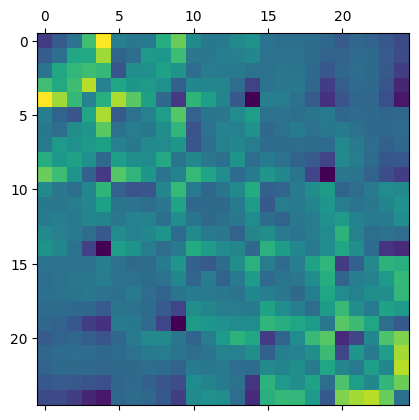

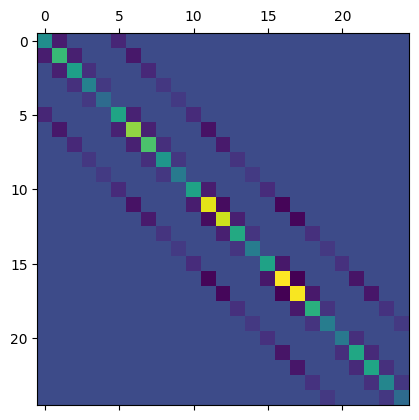

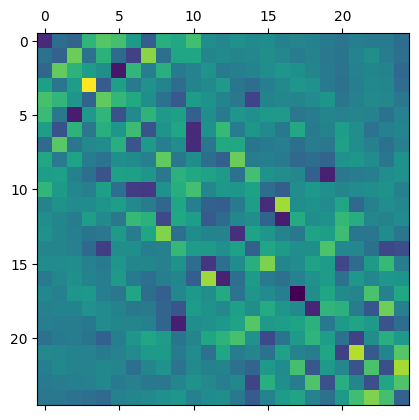

In [35]:
testing(A, fcn)

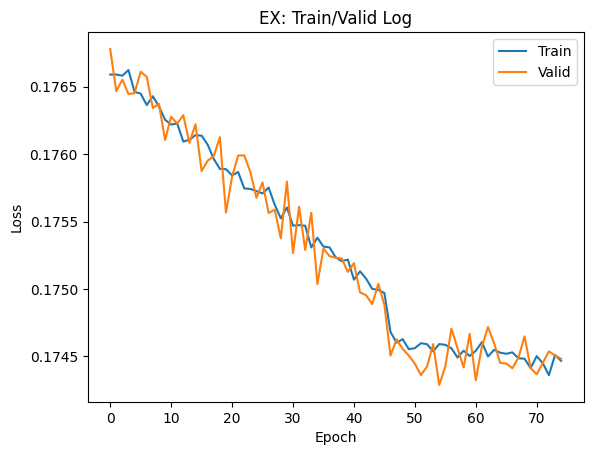

In [44]:
plot_training(train_log_3, valid_log_3)

In [37]:
criterion = InvDistance(inv=1e-2, dev=1.0)
epoches = 300

In [38]:
train_log_4, valid_log_4 = shared_training_loop(epoches, criterion, loader, vloader, model, lr)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train: 0.17493890088796615, Valid: 0.17481836497783662


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Train: 0.17488454295694827, Valid: 0.17476192504167556


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12, Train: 0.17458577723801136, Valid: 0.17454949304461478


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13, Train: 0.17442891776561736, Valid: 0.17431973323225974


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14, Train: 0.17447213806211948, Valid: 0.1745560112595558


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25, Train: 0.17412863898277284, Valid: 0.17418866291642188


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 26, Train: 0.17407106338441372, Valid: 0.1739428673684597


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 27, Train: 0.17376963184773922, Valid: 0.17369762763381005


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 38, Train: 0.17364216466248036, Valid: 0.17354491472244263


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 39, Train: 0.17361886225640774, Valid: 0.17377327680587767


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 40, Train: 0.17365609115362168, Valid: 0.17373709991574288


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 50, Train: 0.17360094383358957, Valid: 0.17370257437229156


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 51, Train: 0.17365444757044315, Valid: 0.1735825777053833


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 52, Train: 0.17355375982820986, Valid: 0.1735439668595791


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 62, Train: 0.17359142191708088, Valid: 0.17355205208063126


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 63, Train: 0.17360405269265175, Valid: 0.17361775442957877


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 64, Train: 0.1735231798887253, Valid: 0.17346958935260773


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 74, Train: 0.1735987164080143, Valid: 0.17357710748910904


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 75, Train: 0.17360341118276118, Valid: 0.17335522830486297


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 76, Train: 0.17359029567241668, Valid: 0.17366846278309822


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 86, Train: 0.17356505109369755, Valid: 0.1734687104821205


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 87, Train: 0.1735563561320305, Valid: 0.17355042934417725


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 91, Train: 0.17363171802461147, Valid: 0.17348354205489158


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 94, Train: 0.17351078793406485, Valid: 0.17348747879266738


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 95, Train: 0.17359802050888537, Valid: 0.17347561925649643


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 104, Train: 0.17355226068198681, Valid: 0.17381622269749641


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 105, Train: 0.17354835471510888, Valid: 0.17353481233119963


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 112, Train: 0.173564924582839, Valid: 0.17343864902853967


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 114, Train: 0.17357420405745505, Valid: 0.17352437496185302


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 115, Train: 0.17355338966846465, Valid: 0.17365723803639413


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 120, Train: 0.1735560380667448, Valid: 0.17367351338267326


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 122, Train: 0.17364956158399583, Valid: 0.17377172470092772


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 123, Train: 0.17363778004050254, Valid: 0.17353993266820908


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 124, Train: 0.17351789040863513, Valid: 0.17346136927604675


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 127, Train: 0.17354291757941245, Valid: 0.1737520256638527


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 129, Train: 0.17357928727567196, Valid: 0.17341597139835357


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 130, Train: 0.1735776935517788, Valid: 0.17327677950263023


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 136, Train: 0.17353315396606922, Valid: 0.17356875896453858


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 139, Train: 0.17353100715577602, Valid: 0.1736558936536312


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 140, Train: 0.17357511168718337, Valid: 0.1736775103211403


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 149, Train: 0.17355259999632835, Valid: 0.17337542459368704


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 152, Train: 0.17354060021042825, Valid: 0.1738386395573616


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 153, Train: 0.1735557615607977, Valid: 0.1735147199034691


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 164, Train: 0.17346451216936112, Valid: 0.17351458206772805


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 165, Train: 0.173606987118721, Valid: 0.1734088398516178


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 174, Train: 0.17347243210673333, Valid: 0.17356409385800362


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 177, Train: 0.173534692004323, Valid: 0.1736676250398159


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 178, Train: 0.17361220447719097, Valid: 0.17383090391755104


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 187, Train: 0.17351124660670758, Valid: 0.17359024077653884


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 190, Train: 0.17356824320554734, Valid: 0.17364348188042641


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 191, Train: 0.17357457821071148, Valid: 0.17329492092132567


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 202, Train: 0.17357481843233108, Valid: 0.17367559686303138


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 203, Train: 0.17358140160143376, Valid: 0.1735190126299858


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 204, Train: 0.17357916693389416, Valid: 0.17372550398111344


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 212, Train: 0.17357429049909115, Valid: 0.17349906295537948


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 213, Train: 0.1734662112593651, Valid: 0.1736114950478077


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 214, Train: 0.1736350499242544, Valid: 0.1736894218623638


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 225, Train: 0.17353918500244617, Valid: 0.17347412467002868


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 226, Train: 0.1735637790709734, Valid: 0.17337580204010009


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 227, Train: 0.1736264750212431, Valid: 0.17369090422987937


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 238, Train: 0.17363967102766037, Valid: 0.17350640431046485


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 239, Train: 0.17358285610377788, Valid: 0.1735835002362728


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 240, Train: 0.1735847666710615, Valid: 0.17352529987692833


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 250, Train: 0.17361414961516858, Valid: 0.17373886510729789


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 251, Train: 0.1735758117735386, Valid: 0.17355243653059005


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 252, Train: 0.1735469681173563, Valid: 0.17366900354623793


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 263, Train: 0.17349608314037324, Valid: 0.17391153544187546


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 264, Train: 0.1735057104229927, Valid: 0.17356112137436866


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 265, Train: 0.17349485445022583, Valid: 0.17324834287166596


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 269, Train: 0.17354887343943118, Valid: 0.17347038879990578


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 270, Train: 0.17358748212456704, Valid: 0.17367729380726815


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 271, Train: 0.17355600938200952, Valid: 0.17385706454515457


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 272, Train: 0.17364123846590518, Valid: 0.17342905208468437


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 273, Train: 0.17346471965312957, Valid: 0.17364054173231125


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 274, Train: 0.17353786739706994, Valid: 0.17346193626523018


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 275, Train: 0.17353782817721367, Valid: 0.17354898601770402


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 276, Train: 0.17350838305056096, Valid: 0.1737235939502716


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 277, Train: 0.17355705058574677, Valid: 0.17371893525123597


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 278, Train: 0.17351097811758517, Valid: 0.17357783943414687


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 279, Train: 0.17364357240498066, Valid: 0.17350310802459717


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 280, Train: 0.17350785326957702, Valid: 0.17359832242131235


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 281, Train: 0.1735337922424078, Valid: 0.1734546534717083


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 282, Train: 0.17347501015663147, Valid: 0.17360589280724525


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 283, Train: 0.17352249798178673, Valid: 0.17355416864156722


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 284, Train: 0.173545872181654, Valid: 0.17388377323746682


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 285, Train: 0.17359869827330113, Valid: 0.17368512079119683


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 286, Train: 0.17359499830007552, Valid: 0.17376697108149528


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 287, Train: 0.17362023411691188, Valid: 0.17371242120862007


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 288, Train: 0.17360033982992173, Valid: 0.173574285954237


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 289, Train: 0.17359959162771701, Valid: 0.1737323072552681


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 290, Train: 0.17355985030531884, Valid: 0.17355051308870315


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 291, Train: 0.1735886883586645, Valid: 0.17380452707409857


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 292, Train: 0.1735859704017639, Valid: 0.1737112034857273


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 293, Train: 0.1735572321563959, Valid: 0.17355643436312676


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 294, Train: 0.17352461387217044, Valid: 0.1737530955672264


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 295, Train: 0.17359795708954334, Valid: 0.17344939917325974


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 296, Train: 0.17352293972671032, Valid: 0.17339058935642243


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 297, Train: 0.17357120287418365, Valid: 0.17363910809159278


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 298, Train: 0.1735851449817419, Valid: 0.1737038867175579


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 299, Train: 0.1736100906431675, Valid: 0.1735548982024193


A COND: 7347.47265625
Inner DET: 0.008821865543723106
Inner COND: 229.13363647460938
tensor(-0.4728)


tensor([[[ 0.0580,  0.1826,  0.2741,  ...,  0.2170,  0.1770,  0.1228],
         [ 0.1826,  0.2578,  0.5059,  ...,  0.2426,  0.1847,  0.1274],
         [ 0.2741,  0.5059,  0.5722,  ...,  0.2416,  0.1750,  0.0764],
         ...,
         [ 0.2170,  0.2426,  0.2416,  ...,  0.4649,  0.3669,  0.8242],
         [ 0.1770,  0.1847,  0.1750,  ...,  0.3669,  0.5668,  0.6990],
         [ 0.1228,  0.1274,  0.0764,  ...,  0.8242,  0.6990,  0.2783]],

        [[-0.0109,  0.1542,  0.3626,  ...,  0.1725,  0.1533,  0.0913],
         [ 0.1542,  0.3962,  0.6886,  ...,  0.2352,  0.1857,  0.1131],
         [ 0.3626,  0.6886,  0.5751,  ...,  0.2709,  0.2120,  0.1040],
         ...,
         [ 0.1725,  0.2352,  0.2709,  ...,  0.4964,  0.3923,  0.7963],
         [ 0.1533,  0.1857,  0.2120,  ...,  0.3923,  0.5859,  0.5784],
         [ 0.0913,  0.1131,  0.1040,  ...,  0.7963,  0.5784,  0.1658]],

        [[-0.0489,  0.2728,  0.4511,  ..., -0.0472, -0.0028,  0.0161],
         [ 0.2728,  0.3790,  0.4129,  ...,  0

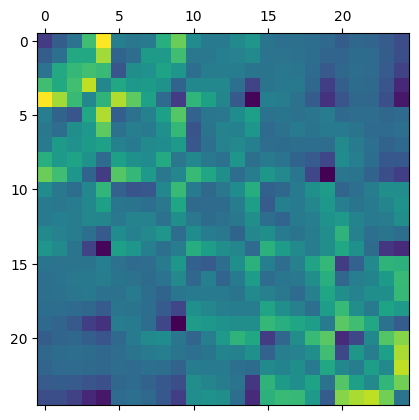

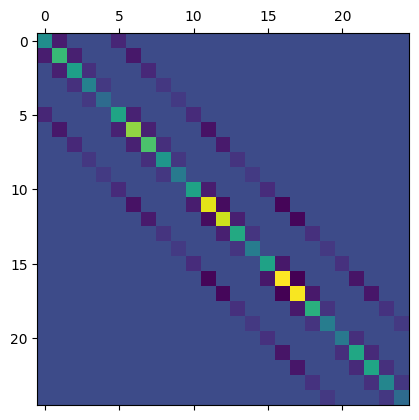

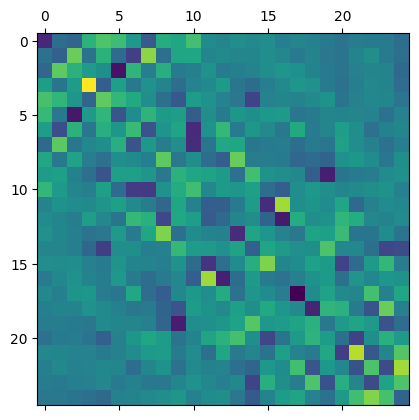

In [39]:
testing(A, fcn)

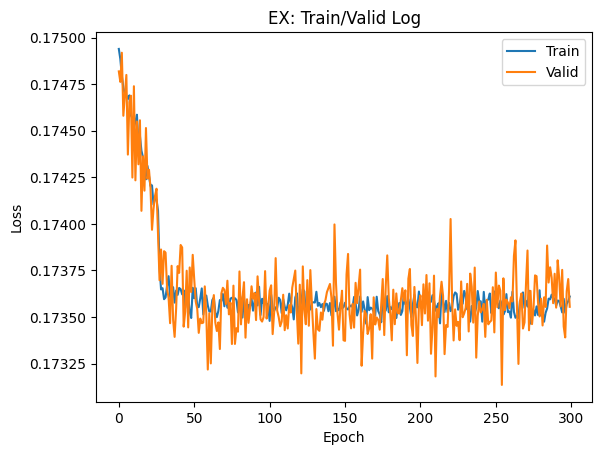

In [45]:
plot_training(train_log_4, valid_log_4)